Per Capita Income Consolidation (1950–Present)

Countries: Singapore, Taiwan, South Korea, Japan

This notebook fetches and consolidates per capita income data from DGBAS and World Bank into an Excel file.

In [2]:
# Core dependencies
!pip install pandas
!pip install openpyxl

# Data source
!pip install wbdata
!pip install pandas wbdata openpyxl

# Visualization
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


📘 Step 1: Replace DGBAS.xlsx file and clean Taiwan GNI Data from DGBAS.xlsx into Taiwan.xlsx

In [3]:
## Import necessary libraries
import pandas as pd

# Load the raw DGBAS file
raw_df = pd.read_excel("dgbas.xlsx", header=None)

# Extract the useful data range
# Real data starts at row 4 (index 4)
data_block = raw_df.iloc[4:, [0, 1, 9, 10, 11]]
data_block.columns = ["Year", "Population", "GNI_CurrentUSD_million", "PerCapitaGNI_NT", "PerCapitaGNI_CurrentUSD"]

# Drop rows where Year is not a valid number
data_block = data_block[pd.to_numeric(data_block["Year"], errors="coerce").notna()]
data_block["Year"] = data_block["Year"].astype(int)

# Add additional required columns for standardization
data_block["Country"] = "Taiwan"
data_block["Source"] = "DGBAS"
data_block["PerCapitaIncome_ConstantUSD"] = None
data_block["GDP_CurrentUSD"] = None
data_block["PPP_Adjusted"] = None

# Reorder columns (renaming the GNI field accordingly)
taiwan_clean = data_block[[ 
    "Country", "Year", "PerCapitaGNI_CurrentUSD", "PerCapitaIncome_ConstantUSD",
    "GDP_CurrentUSD", "Population", "PPP_Adjusted", "Source", "GNI_CurrentUSD_million"
]]

# Save to Excel
taiwan_clean.to_excel("taiwan_gni.xlsx", index=False)
print("✅ Saved cleaned Taiwan GNI data to taiwan_gni.xlsx")

✅ Saved cleaned Taiwan GNI data to taiwan_gni.xlsx


🌍 Step 2: Fetch GNI per Capita for SG, JP, KR (World Bank via wbdata)

In [4]:
# Import libraries
import pandas as pd
import wbdata
import datetime

# Indicator and date range (GNI per capita, current USD)
indicator = {"NY.GNP.PCAP.CD": "PerCapitaGNI_CurrentUSD"}
data_date = (datetime.datetime(1960, 1, 1), datetime.datetime(2023, 1, 1))

# Country ISO3 codes
countries = {
    "SGP": "Singapore",
    "JPN": "Japan",
    "KOR": "Korea"
}

# Fetch data for each country
def fetch_from_wb(iso_list, country_name):
    df = wbdata.get_dataframe(indicator, country=iso_list, date=data_date)
    df.reset_index(inplace=True)
    df = df.rename(columns={
        "date": "Year",
        "country": "CountryCode",
        list(indicator.values())[0]: "PerCapitaGNI_CurrentUSD"
    })

    df["Year"] = pd.to_datetime(df["Year"]).dt.year
    df["Country"] = country_name
    df["Source"] = "World Bank (wbdata)"
    df["PerCapitaIncome_ConstantUSD"] = None
    df["Population"] = None
    df["PPP_Adjusted"] = None
    df["GNI_CurrentUSD_million"] = None

    return df[[ 
        "Country", "Year", "PerCapitaGNI_CurrentUSD", "PerCapitaIncome_ConstantUSD",
        "Population", "PPP_Adjusted", "Source", "GNI_CurrentUSD_million"
    ]]

# Apply to all 3 countries
sg_df = fetch_from_wb(["SGP"], "Singapore")
jp_df = fetch_from_wb(["JPN"], "Japan")
kr_df = fetch_from_wb(["KOR"], "Korea")

# Combine and export
combined_gni = pd.concat([sg_df, jp_df, kr_df])
combined_gni.to_excel("openbb_countries.xlsx", index=False)
print("✅ Saved World Bank GNI data to openbb_countries.xlsx")

✅ Saved World Bank GNI data to openbb_countries.xlsx


🔗 Step 3: Combine Taiwan + World Bank Data

In [5]:
# Load both data sources
taiwan = pd.read_excel("taiwan_gni.xlsx")
openbb_countries = pd.read_excel("openbb_countries.xlsx")

# Combine and sort
combined = pd.concat([taiwan, openbb_countries])
combined = combined.sort_values(by=["Country", "Year"]).reset_index(drop=True)

#Export long form data
combined.to_excel("per_capita_income_long.xlsx", index=False)  # full long-form data
print("✅ Exported long format dataset.")

✅ Exported long format dataset.


In [7]:
# 📊 Pivot data for easier comparison between countries (wide format)
combined["Country"] = combined["Country"].replace({"Korea": "South Korea"})  # fix naming issue
comparison_df = combined.pivot(index="Year", columns="Country", values="PerCapitaGNI_CurrentUSD")
comparison_df = comparison_df[["Japan", "Singapore", "South Korea", "Taiwan"]]  # ensure order
comparison_df = comparison_df.sort_index(ascending=False)

# Export visual comparison
comparison_df.to_excel("per_capita_income_comparison.xlsx")
print("✅ Exported wide format dataset.")

✅ Exported wide format dataset.


📊 Optional: Preview Cleaned Data

In [8]:
# Load final dataset
# df = pd.read_excel("per_capita_income_long.xlsx")
df = pd.read_excel("per_capita_income_comparison.xlsx")
df.head(10)

,Year,Japan,Singapore,South Korea,Taiwan
0,2025,NaN,NaN,NaN,NaN
1,2024,NaN,NaN,NaN,35188.0
2,2023,39350.0,70590.0,35490.0,33525.0
3,2022,42550.0,66970.0,36160.0,33828.0
4,2021,43670.0,64970.0,35180.0,33987.0
5,2020,40940.0,55290.0,33040.0,29649.0
6,2019,41970.0,58810.0,33830.0,26759.0
7,2018,41800.0,56550.0,32740.0,26531.0
8,2017,38930.0,54920.0,30290.0,25745.0
9,2016,38460.0,53310.0,29330.0,23684.0


📈 Optional: Plot GNI Per Capita Over Time (Current USD)

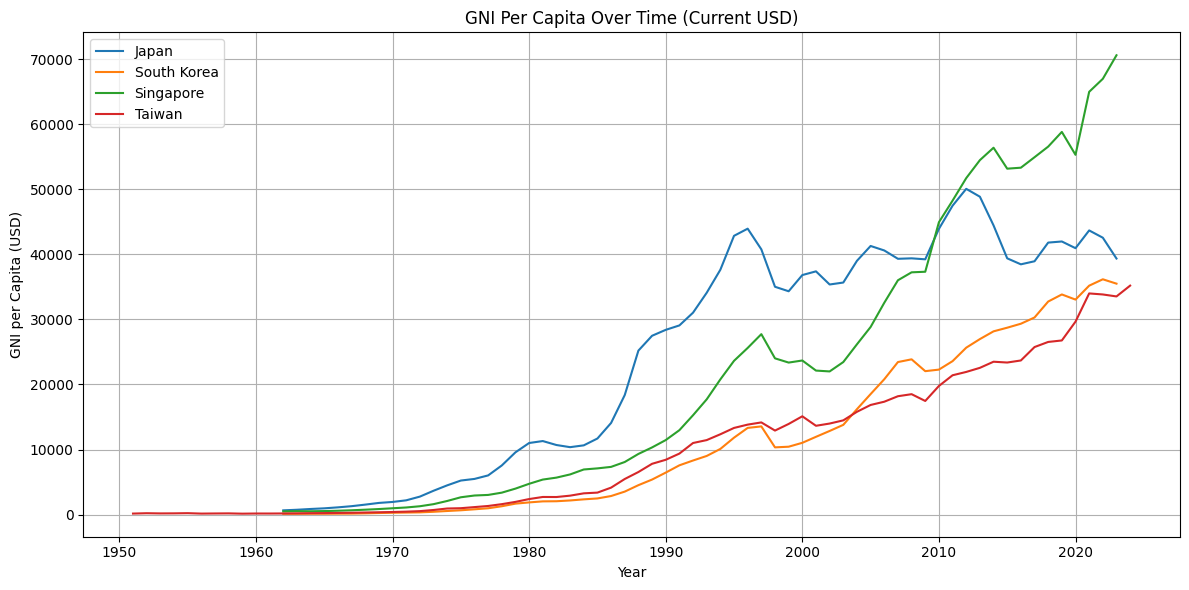

In [11]:
import matplotlib.pyplot as plt

# Standardize country name to avoid mislabeling
combined["Country"] = combined["Country"].replace({"Korea": "South Korea"})

# Plot
plt.figure(figsize=(12, 6))
for country in combined["Country"].unique():
    subset = combined[combined["Country"] == country]
    plt.plot(subset["Year"], subset["PerCapitaGNI_CurrentUSD"], label=country)

plt.title("GNI Per Capita Over Time (Current USD)")
plt.xlabel("Year")
plt.ylabel("GNI per Capita (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📉 Optional: Histogram of GNI Per Capita (All Years)

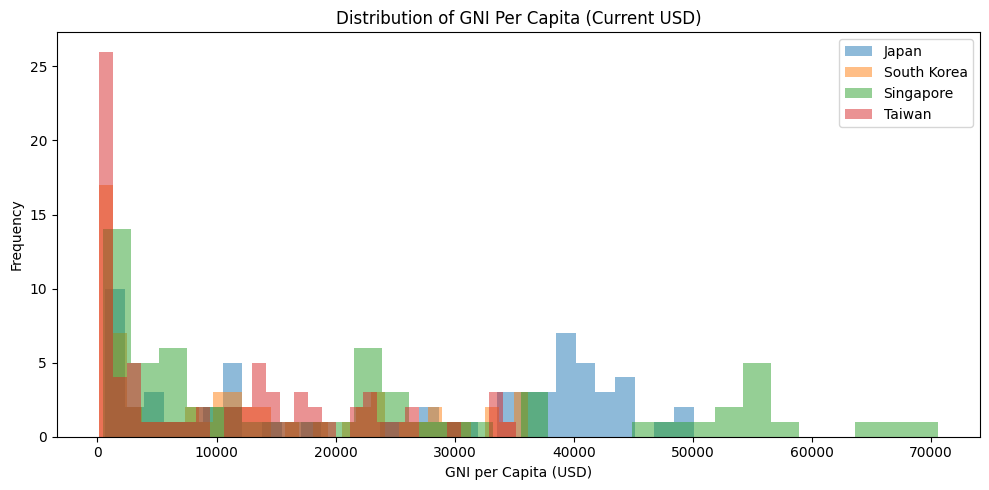

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for country in combined["Country"].unique():
    subset = combined[combined["Country"] == country]
    plt.hist(subset["PerCapitaGNI_CurrentUSD"].dropna(), bins=30, alpha=0.5, label=country)

plt.title("Distribution of GNI Per Capita (Current USD)")
plt.xlabel("GNI per Capita (USD)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

📊 Optional: Show Data Summary by Country

In [13]:
combined.groupby("Country")["PerCapitaGNI_CurrentUSD"].describe()

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Japan,62.0,25024.032258,17165.731060,650.0,6402.5,32560.0,39380.0,50060.0
Singapore,62.0,22276.612903,21501.971312,490.0,3107.5,16490.0,36925.0,70590.0
South Korea,62.0,11847.258065,11928.011964,120.0,1047.5,8660.0,22220.0,36160.0
Taiwan,74.0,9982.756757,10524.388830,140.0,366.0,6004.5,17221.0,35188.0
